# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Advanced-Sections: Homework 1 - Transfer Learning




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
import os
import pathlib
working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit. (Exception - you may skip the cells where you train neural networks, running the cells which load previously saved weights instead. However, **don't delete/overwrite the output that model.fit produced during training!**)

**Names of person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import os
# For colab: Import the TF V2 through this magic command
# %tensorflow_version 2.x 
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

#import keras
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image

# Check the Version of the Tensor Flow. It should be the version 2
print(tf.__version__)

2.0.0


<div class="theme"> Overview </div> 


**How to use existing models for transfer learning:**
Transfer learning is a Machine Learning method where we use the knowledge gained while solving a problem to solve another problem. For instance, when the training data is too small to train a deep network, we can load a pre-trained network and then fine-tuning a few of its parameters by using our small training set.
In this homework you will be engaged with two usefull applications of transfer learning. (a) Train a deep network with a small dataset. (b) Improve the feature extraction of a pre-train deep network. In particular, the aim of the homework is:
- Learn the idea of transfer learning through a simple classification example
- Build  new networks by using pre-trained models. Combine  pre-trained layers with new layers, and train specific layers.
- Get good  performance of image classification and feature extraction by training with small datasets.


The task of this homework is to design a network for classifying and extracting features for two different categories:  dogs and flowers.  The pre-trained model that  will be used is the *MobileNet* which is trained in 1000 categories with 1000 images per category. Although this pre-trained model classifies and extract features from 1000 categories pretty well, there are some other categories that the pre-trained MobileNet does not perform very well. In this homework, we will improve the performance, namely the classification and the feature extraction abilities of the MobileNet on those categories. 

----------


<div class='exercise'><b> Question 1: Load and inspect the pre-trained MobileNet  [40pts total] </b></div>


In this question, we have to load the pre-train the MobileNet. Then use the images and perfrom some classifications. Check whether the MobileNet classifies well and whether it is not. Afterwards, you need to make a deeper investigation. In particular, explore the feature maps extracted by the MobileNet. In this task you need to use the Principal Component Analysis method (PCA) to visualize the abstract feature maps space. 

**1.1. [10pts]**  Load a pre-trained MobileNet and inspect its performance in some of the images from the given `trainData`, or `testData`, or `pcaData` sets (these are new data for the pretrained MobileNet). Is the performance similar for all the  categories?


Set the directory where the dataset are located with the name `pathFolder`

In [3]:
#your code here
pathFolder = 'data/'

Check that the pathFolder is correct by showing the following image

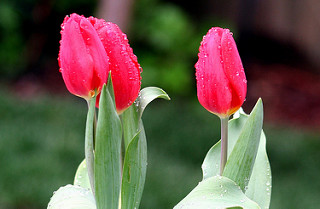

In [4]:
Image(filename= pathFolder + 'trainData/tulips/100930342_92e8746431_n.jpg')

Load the pre-train MobileNet trained in the `imagenet` dataset

In [5]:
#your code here
mobile = tf.keras.applications.mobilenet.MobileNet(weights='imagenet')

Inspect the MobileNet architecture and define the image size as `IMG_SIZE` and the input shape as `IMG_SHAPE`

In [6]:
#your code here
mobile.summary()
IMG_SIZE  = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

**Three helper functions**

`prepare_image`: A function to prepare the images for the MobileNet. Input shape: (1, 224, 224, 3)

In [7]:
def prepare_image(img_path, img_size = 224):
    img = image.load_img(img_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

`mobileClassifier`: A helper function for doing the classification by using MobileNet

In [8]:
def mobileClassifier(imagePath, pathFolder=pathFolder, mobile=mobile):
    imagePathFull = pathFolder + imagePath
    preprocessed_image = prepare_image(imagePathFull)
    # Use mobileNet to classify the image
    predictions = mobile.predict(preprocessed_image)
    results = imagenet_utils.decode_predictions(predictions)
#print(results)
    return results

`Prepare the data`

Load the data into the ImageDataGenerator. You might want to use  data augmentation:

 https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/ 


In [9]:
# this is a function to avoid reading secret directory. You might also need it later
filter_hidden = lambda my_list: [x for x in my_list if not x.startswith('.')]


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                                 horizontal_flip=True, 
                                                 rotation_range=45, 
#                                                 zoom_range=[0.8,1.0]
                                ) 

test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 


# TRAINING set
pathTrain = pathFolder + 'trainData/'
listGroupsTrain = filter_hidden(os.listdir(pathTrain)) # the directory path

# TESTING set
pathTest = pathFolder + 'testData/'
listGroupsTest = filter_hidden(os.listdir(pathTest)) # the directory path

##
## SOMETIME THE list of training groups is in a different order than the list of testing, alhough they have the same name
listGroupsTest = listGroupsTrain
##


# Load the data into the ImageDataGenerator
train_generator=train_datagen.flow_from_directory(pathTrain,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True, 
                                                 classes=listGroupsTrain)



test_generator=test_datagen.flow_from_directory(pathTest,
                                                 target_size=(IMG_SIZE,IMG_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=False, 
                                                 classes=listGroupsTest)

Found 843 images belonging to 5 classes.
Found 104 images belonging to 5 classes.


In [10]:
listGroupsTrain

['German_Shepherd', 'labrador', 'daisy', 'tulips', 'rose']

In [11]:
listGroupsTest

['German_Shepherd', 'labrador', 'daisy', 'tulips', 'rose']

Classify some of the images. Choose images from different categories

In [12]:
#your code here
mobileClassifier('pcaData/labrador/5.labrador_retriever.jpg')

[[('n02099712', 'Labrador_retriever', 0.9703214),
  ('n02099601', 'golden_retriever', 0.014126321),
  ('n02104029', 'kuvasz', 0.0036305177),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.0017487509),
  ('n02108422', 'bull_mastiff', 0.0011949409)]]

In [13]:
#your code here
mobileClassifier('trainData/German_Shepherd/9.german.jpg')

[[('n02106662', 'German_shepherd', 0.97396696),
  ('n02105162', 'malinois', 0.00992742),
  ('n02111129', 'Leonberg', 0.007395888),
  ('n02093991', 'Irish_terrier', 0.002168713),
  ('n02096294', 'Australian_terrier', 0.0018022488)]]

In [14]:
#your code here
mobileClassifier('trainData/tulips/100930342_92e8746431_n.jpg')

[[('n03930313', 'picket_fence', 0.29128855),
  ('n02280649', 'cabbage_butterfly', 0.123460084),
  ('n12057211', "yellow_lady's_slipper", 0.09701885),
  ('n11939491', 'daisy', 0.088766344),
  ('n02281406', 'sulphur_butterfly', 0.07786752)]]

In [15]:
#your code here
mobileClassifier('trainData/rose/rose.jpg')

[[('n04522168', 'vase', 0.8190549),
  ('n01943899', 'conch', 0.032665074),
  ('n01910747', 'jellyfish', 0.026726542),
  ('n01770081', 'harvestman', 0.014492855),
  ('n02280649', 'cabbage_butterfly', 0.008324888)]]

Make some comments


#### Your comments here:

The pre-trained MobileNet classifies very well the breed of dogs.
However, it is not doing good job in the classification of kind of flowers.

**1.2. [15pts]** Explore the feature maps extracted by the pre-train MobileNet. In particular, extract the features that MobileNet learns for three images, one from each category of dogs and flowers.
 
First, prepare the two images from each category

In [16]:
#your code here
preprocessed_image1 = prepare_image(pathFolder + 'trainData/German_Shepherd/9.german.jpg')
preprocessed_image2 = prepare_image(pathFolder + 'trainData/rose/rose.jpg')
#preprocessed_image2 = prepare_image(pathFolder + 'trainData/daisyTr/daisy.jpg')

Inspect the first convolution layer: `conv1`. Exctract and plot the first five features maps of each image.

Hint: Load only up to the first convolution layer. Use `summary()` to check the name of the layer.


shape:  (1, 112, 112, 32) 

type:  <class 'numpy.ndarray'> 



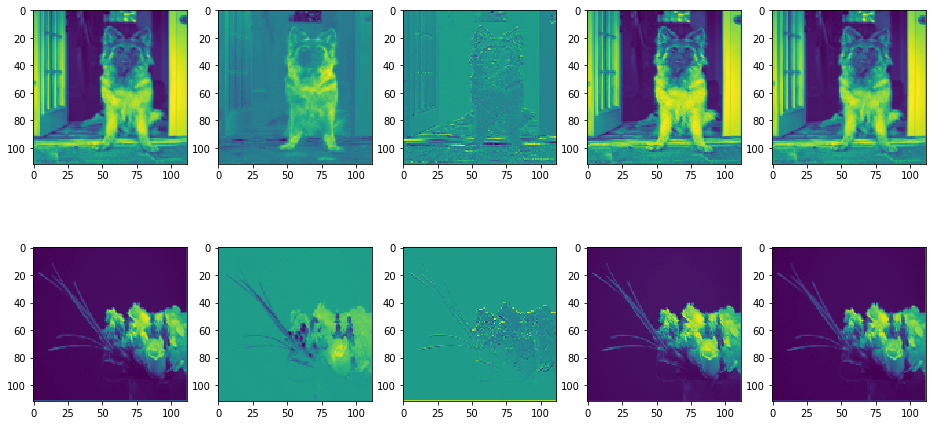

In [17]:
#your code here

# load the model up to first convolution layers
inspectLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv1').output)

# Exctract the feature maps
features1 = inspectLayerModel.predict(preprocessed_image1)
features2 = inspectLayerModel.predict(preprocessed_image2)

print('shape: ', features1.shape , '\n')
print('type: ',type(features1), '\n')

# Plot the first N=5 feature maps for each image
N=5
plt.figure(figsize=[16,8])
for i in range(N):
    # i in a different feature of each imge
    plt.subplot(2,N,i+1)
    plt.imshow(features1[0,:,:,i])
    plt.subplot(2,N,N+i+1)
    plt.imshow(features2[0,:,:,i])

Inpsect the last 2D convolution layer: `conv_pw_13`. Exctract and plot the first five features maps of each image.

shape:  (1, 7, 7, 1024) 



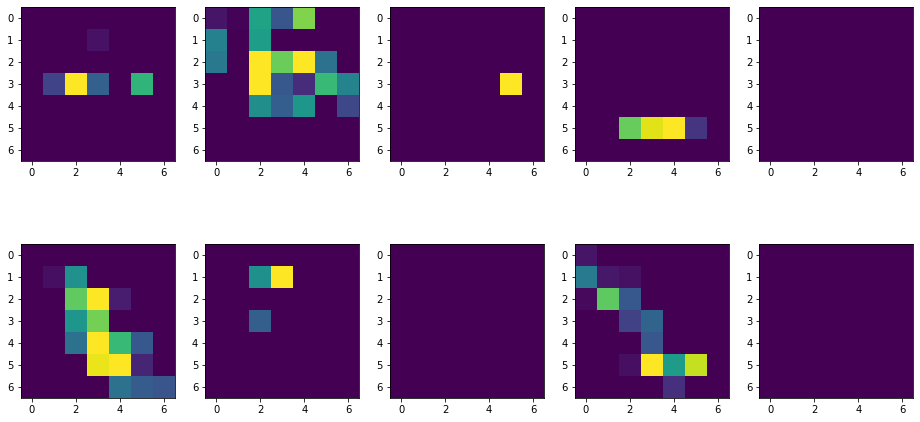

In [18]:
#your code here

# load the model up to first convolution layers
inspectLayerModel = tf.keras.models.Model(inputs=mobile.input, outputs=mobile.get_layer('conv_pw_13_relu').output)

#Extract the feature maps
features1 = inspectLayerModel.predict(preprocessed_image1)
features2 = inspectLayerModel.predict(preprocessed_image2)

print('shape: ', features1.shape, '\n')

# Plot the first N=5 feature maps for each image
plt.figure(figsize=[16,8])
for i in range(N):
    plt.subplot(2,N,i+1)
    plt.imshow(features1[0,:,:,i])
    plt.subplot(2,N,N+i+1)
    plt.imshow(features2[0,:,:,i])

Can we draw any conclusions or understand anything from these feature maps? Obviously no. It is a very abstract representation. We can further investigate the feature maps by using **Principal Component Analysis (PCA)** method.

**1.3. [15pts]** Use PCA to study the extracted feature maps. In particular, perform a PCA transform for the extracted from the last convolution layer features.

To save some time you might use only 20 images per category. These data are store at `pcaData`.


Define the layer from which we  extract the features

In [19]:
#your code here
featuresLayerModel = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

Two intermedia steps: (A)  Count the total images and the categories of the dataset that is located in the `pcaData` directory. (B)  Prepare the data for the PCA and assign the associate name of category of each image

In [20]:
#your code here

# dataset location
pathPCA = pathFolder + 'pcaData/'

# count the number of groups as: number_groups
listGroups = filter_hidden(os.listdir(pathPCA) )

number_groups = len(listGroups)
print(number_groups  , 'groups:', listGroups)
## count the pictures as: totalImages
totalImages = 0
for pathF in listGroups:
    pathF1 = pathPCA + pathF
    listFiles = filter_hidden(os.listdir(pathF1))
    totalImages += len(listFiles)
    
#########################################

# PCA takes a 1D object per image
features_flatten = np.zeros([totalImages,7*7*1024]) 

i=0
for pathF in listGroups:
    pathF1 = pathPCA + pathF + "/"
    for imgName in os.listdir(pathF1):
        pathImag = pathF1 + imgName
        preprocessed_img = prepare_image(pathImag)
        features = featuresLayerModel.predict(preprocessed_img)
        features_flatten[i,:] = features.flatten()
        i += 1  

5 groups: ['German_Shepherd', 'labrador', 'rosePCA', 'daisyPCA', 'tulipsPCA']


Perform PCA transform and keep  onlythe first two principal components

In [21]:
#your code here

pca = PCA(n_components=2)
transferValues = features_flatten
transferVal_pca = pca.fit_transform(transferValues)

Plot the results obtained by PCA transform. Use different color/symbol to represent each of the categories.

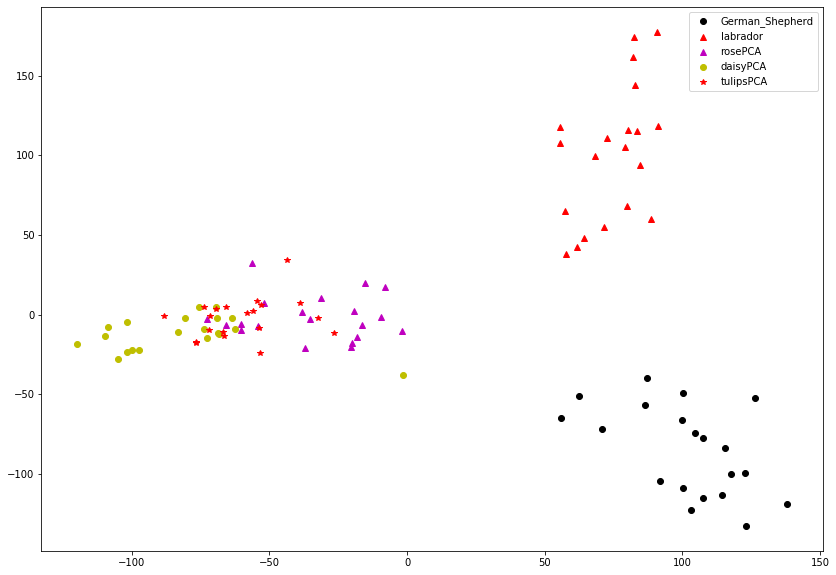

In [22]:
#your code here

x = transferVal_pca[:, 0]
y = transferVal_pca[:, 1]

mystyle = ['ok', '^r','^m','oy','*r','om', '*b','^b']

plt.figure(figsize=[14,10])

# The number of images per category in the pca dataset 
imgC = 20

for i in range(number_groups):
    plt.plot(x[i*imgC : imgC*(i+1)],y[i*imgC : imgC*(i+1)], mystyle[i], label=listGroups[i] )
plt.legend();

Make some comments

#### Your comments here:
We observe three clusters. One cluster corresponds to the flowers and the other two correspond to the two dogs class. Consequently, the pre-trained MobileNet can extract features maps pretty well and is able to classify the flowers from the dogs.

Focusing now in each category, we observe that in the class of dogs the Mobile net can also classify different breed of dogs. On the other hand,  it fails to classify the different kind of flowers. Hence, we have  detected the reason that the MobileNet fails in classifying very well the flowers.

<div class='exercise'><b> Question 2: Improve the classification ability of the pre-trained MobileNet  [30pts total] </b></div>



How can we improve the MobileNet?

The pre-trained MobileNet architecture shows quite good performance. Nevertheless, we want to improve  its classification ability  on the class of flowers. 
Training the MobileNet from  scratch by using only images  of dogs and flowers we will be overfitting because our dataset is too small and the network very expressive. So, let's use *transfer learning*.

Use the pre-trained model and re-train just a few layers (fast and efficient).
Since the convolution layers of the MobileNet can extract  abstract features from the images we can use (transfer) this knowledge by  freezing the convolution pre-trained layers. In particular, we can adjust and train one or a few new layers to classify the new data from the extracted features


**2.1. [15pts] Add and train a new dense layer on the top of the pre-trained MobileNet**


Use all the pre-trained convolution layers obtained by MobileNet (`base` model) and adjust one or more new dense layers in the end (`head`). Then, freeze the base layers and train only the fully connected layers. 

Define the base model

In [76]:
#your code here
transferModel_base = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

Create the new architecture by transfering the convolutions layers from the MobileNet. The name of the new architecture should be  `mobile_tl`.


In [77]:
#your code here

# Freeze the mobileNet's convolution layers
transferModel_base.trainable = False

# Regularize the dense layers 
kernel_weight = 0.002
bias_weight = 0.002


mobile_tl = tf.keras.Sequential([
      transferModel_base,
      tf.keras.layers.GlobalAveragePooling2D(),
       Dense(128, activation='relu', name="dense_extra",
                               kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=tf.keras.regularizers.l1(bias_weight)),
       layers.Dropout(0.5),
      Dense(number_groups, activation='softmax', name="dense_head",
                                 kernel_regularizer=tf.keras.regularizers.l1(kernel_weight), 
                                 bias_regularizer=tf.keras.regularizers.l1(bias_weight)),
])


#mobile_tl.summary()

**2.2. [15pts] Compile the model and show the perfrormance of the new model**

Define your optimizer, the loss function, regularization, and the number of training period (epochs).  
To inspect the network performance after the training, you might store the Loss functions and the accuracy.

For the specific example, the validation loss should be less than 5 and the accuracy on the validation set should be at least 60%. A training between ten epochs should be fine but you can train more.


In [78]:
#your code here

lrate_head = 0.002
head_epochs=10
mobile_tl.compile(optimizer=tf.keras.optimizers.Adam(lr=lrate_head), 
                  loss=tf.keras.losses.categorical_crossentropy , metrics=['accuracy'] )

In [79]:
#your code here

step_size_train=train_generator.n//train_generator.batch_size

history_mobile_tl = mobile_tl.fit_generator(generator=train_generator,
                                       validation_data=test_generator,
                                       steps_per_epoch=step_size_train,
                                       epochs=head_epochs)


Epoch 1/10
13/13 [==============================] - 18s 1s/step - loss: 10.6856 - accuracy: 0.4300 - val_loss: 9.1051 - val_accuracy: 0.7019
Epoch 2/10
13/13 [==============================] - 20s 2s/step - loss: 8.2505 - accuracy: 0.7240 - val_loss: 7.7847 - val_accuracy: 0.7212
Epoch 3/10
13/13 [==============================] - 19s 1s/step - loss: 6.5648 - accuracy: 0.8164 - val_loss: 6.0295 - val_accuracy: 0.7596
Epoch 4/10
13/13 [==============================] - 18s 1s/step - loss: 5.2294 - accuracy: 0.8421 - val_loss: 4.8726 - val_accuracy: 0.7308
Epoch 5/10
13/13 [==============================] - 18s 1s/step - loss: 4.2287 - accuracy: 0.8447 - val_loss: 3.8164 - val_accuracy: 0.7885
Epoch 6/10
13/13 [==============================] - 19s 1s/step - loss: 3.3365 - accuracy: 0.8870 - val_loss: 3.2466 - val_accuracy: 0.7788
Epoch 7/10
13/13 [==============================] - 16s 1s/step - loss: 2.7424 - accuracy: 0.8815 - val_loss: 2.5779 - val_accuracy: 0.7692
Epoch 8/10
13/13 [=

Plot the loss and the accuracy for training and validation

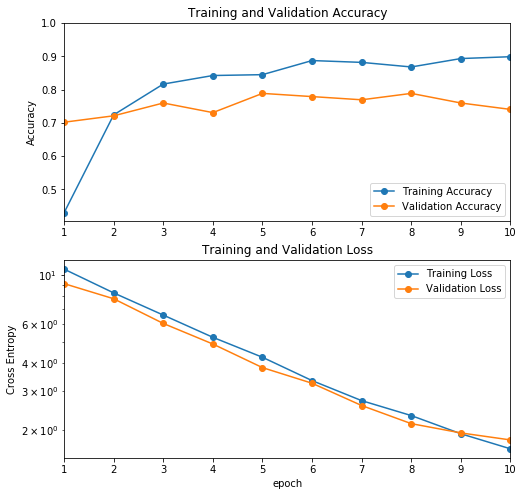

In [80]:
#your code here
epochsVec = np.linspace(1,head_epochs,head_epochs)

acc = history_mobile_tl.history['accuracy']
val_acc = history_mobile_tl.history['val_accuracy']

loss = history_mobile_tl.history['loss']
val_loss = history_mobile_tl.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochsVec,acc, '-o', label='Training Accuracy')
plt.plot(epochsVec,val_acc, '-o', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlim([1, head_epochs])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.semilogy(epochsVec,loss,'-o', label='Training Loss')
plt.semilogy(epochsVec,val_loss,'-o', label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlim([1, head_epochs])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


<div class='exercise'><b> Question 3: Improve the extraction of the feature maps [30pts total] </b></div>


**3.1. [pts 15] Fine Tuning**

Take the previous based model and unfreeze the convolution layers. Create a new model with the base model and with the dense layer used in the `model_tl`. Then, train the entire network. Name the new model as `mobile_tuned`.

In [81]:
#your code here

transferModel_base_tuned = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)

# mobile_tl.summary()

# unfreeze the convolution layers
transferModel_base_tuned.trainable = True

# define the architecture
mobile_tuned = tf.keras.Sequential([
    transferModel_base_tuned,
    tf.keras.layers.GlobalAveragePooling2D(),
    mobile_tl.get_layer('dense_extra'),
    layers.Dropout(0.5),
    mobile_tl.get_layer('dense_head')
])

In [82]:
# check the summary()
mobile_tuned.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1024)              0         
_________________________________________________________________
dense_extra (Dense)          (None, 128)               131200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_head (Dense)           (None, 5)                 645       
Total params: 3,360,709
Trainable params: 3,338,821
Non-trainable params: 21,888
_________________________________________________________________


**3.2. [15pts] Compile the model, present the perfrormance of the new model, and visualize the feature maps with PCA**


In [83]:
#your code here
base_epochs=10
lrate_base = lrate_head/20


mobile_tuned.compile(optimizer=tf.keras.optimizers.Adam(lr=lrate_base), 
                  loss=tf.keras.losses.categorical_crossentropy , metrics=['accuracy'] )


step_size_train=train_generator.n//train_generator.batch_size

history_mobile_tuned = mobile_tuned.fit_generator(generator=train_generator,
                                                   validation_data=test_generator,
                                                   steps_per_epoch=step_size_train,
                                                   epochs=base_epochs)



Epoch 1/10
13/13 [==============================] - 19s 1s/step - loss: 1.4579 - accuracy: 0.8986 - val_loss: 1.5217 - val_accuracy: 0.7981
Epoch 2/10
13/13 [==============================] - 19s 1s/step - loss: 1.3016 - accuracy: 0.9397 - val_loss: 1.3020 - val_accuracy: 0.9135
Epoch 3/10
13/13 [==============================] - 20s 2s/step - loss: 1.2179 - accuracy: 0.9525 - val_loss: 1.2457 - val_accuracy: 0.9423
Epoch 4/10
13/13 [==============================] - 19s 1s/step - loss: 1.1545 - accuracy: 0.9653 - val_loss: 1.1755 - val_accuracy: 0.9808
Epoch 5/10
13/13 [==============================] - 20s 2s/step - loss: 1.0795 - accuracy: 0.9782 - val_loss: 1.1013 - val_accuracy: 0.9808
Epoch 6/10
13/13 [==============================] - 18s 1s/step - loss: 1.0511 - accuracy: 0.9743 - val_loss: 1.1115 - val_accuracy: 0.9519
Epoch 7/10
13/13 [==============================] - 21s 2s/step - loss: 0.9919 - accuracy: 0.9820 - val_loss: 1.1466 - val_accuracy: 0.8942
Epoch 8/10
13/13 [==

Visualize the performance (in comparison with the `mobile_tl`) and make some comments

In [85]:
#your code here

epochsVec2 = np.linspace(1,head_epochs+base_epochs,head_epochs+base_epochs)

acc += history_mobile_tuned.history['accuracy']
val_acc += history_mobile_tuned.history['val_accuracy']

loss += history_mobile_tuned.history['loss']
val_loss += history_mobile_tuned.history['val_loss']




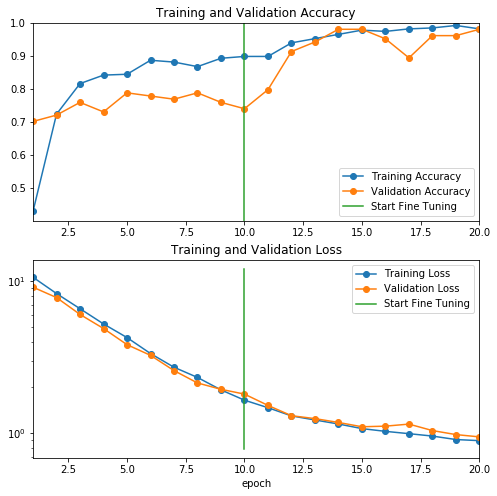

In [86]:
#your code here

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochsVec2,acc,'-o', label='Training Accuracy')
plt.plot(epochsVec2,val_acc,'-o', label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlim([1, head_epochs+base_epochs])
plt.plot([head_epochs,head_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.semilogy(epochsVec2, loss,'-o',  label='Training Loss')
plt.semilogy(epochsVec2, val_loss,'-o', label='Validation Loss')
plt.xlim([1, head_epochs+base_epochs])
plt.plot([head_epochs,head_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


#### Your comments here:

After the fine-tuning we observe that the training is improved. Namely, the loss descreases while the accuracy increases.

**Investigate the feature extraction by using PCA**

In [87]:
#your code here

features_flatten_tuned = np.zeros([totalImages,7*7*1024]) 

i=0
for pathF in listGroups:
    pathF1 = pathPCA + pathF + "/"
    for imgName in os.listdir(pathF1):
        pathImag = pathF1 + imgName
        preprocessed_img = prepare_image(pathImag)
        features = transferModel_base_tuned.predict(preprocessed_img)
        features_flatten_tuned[i,:] = features.flatten()
        i += 1  
        
pca = PCA(n_components=2)
transferValues = features_flatten_tuned
transferVal_pca_tuned = pca.fit_transform(transferValues)


Visualize the results obtained by PCA

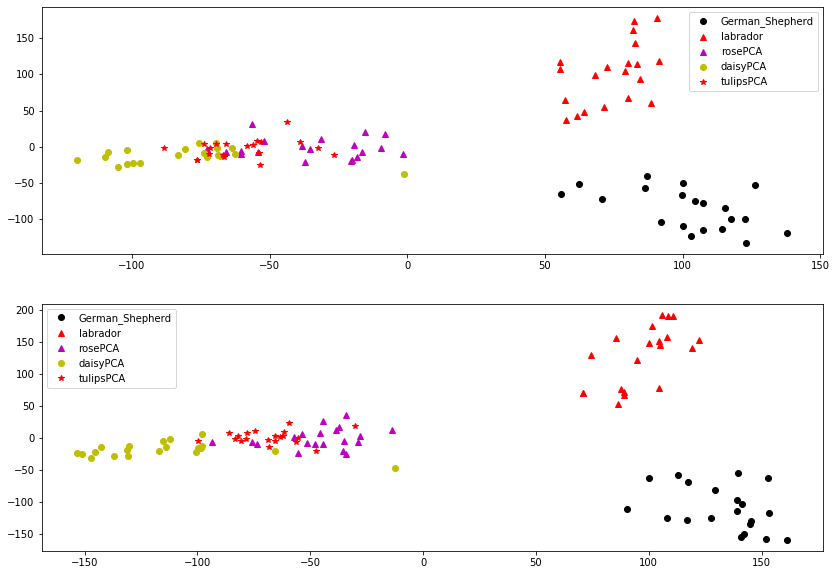

In [88]:
#your code here

plt.figure(figsize=[14,10])

plt.subplot(2,1,1)
x = transferVal_pca[:, 0]
y = transferVal_pca[:, 1]
mystyle = ['ok', '^r','^m','oy','*r','om', '*b','^b']
# The number of images per category in the pca dataset 
imgC = 20

for i in range(number_groups):
    plt.plot(x[i*imgC : imgC*(i+1)],y[i*imgC : imgC*(i+1)], mystyle[i], label=listGroups[i] )
plt.legend();


#######
plt.subplot(2,1,2)
x = transferVal_pca_tuned[:, 0]
y = transferVal_pca_tuned[:, 1]

mystyle = ['ok', '^r','^m','oy','*r','om', '*b','^b']

# The number of images per category in the pca dataset 
imgC = 20

for i in range(number_groups):
    plt.plot(x[i*imgC : imgC*(i+1)],y[i*imgC : imgC*(i+1)], mystyle[i], label=listGroups[i] )
plt.legend();

Make some comments

#### Your comments here:
Now, the PCA shows that in the feature space the features of  the flowers are separated better than previously. So indeed, the fine-tuning improves the feature extraction ability of the MobileNet.

## **References**

- https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299
- https://towardsdatascience.com/review-mobilenetv1-depthwise-separable-convolution-light-weight-model-a382df364b69
- https://www.alibabacloud.com/blog/part-3-image-classification-using-features-extracted-by-transfer-learning-in-keras_595291
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://arxiv.org/abs/1704.04861    

